Hypothesis: There exists a clear embedding bias between art & general movies as their nature and end goal (commericial vs art) clearly differs.

Step 1: Environment Setup and Library Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc
from konlpy.tag import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import plotly.express as px  # Plotly for interactive plots
from sklearn.manifold import TSNE  # t-SNE for dimensionality reduction
import pandas as pd


# 1. Automatic Korean Font Configuration based on OS
system_name = platform.system()  # Get current OS name

if system_name == 'Darwin':  # If Mac OS
    rc('font', family='AppleGothic')  # Set font to AppleGothic
elif system_name == 'Windows':  # If Windows
    path = "c:/Windows/Fonts/malgun.ttf"  # Path to Malgun Gothic
    font_name = font_manager.FontProperties(fname=path).get_name()  # Get font name
    rc('font', family=font_name)  # Set font
else:  # If Linux (e.g., Google Colab)
    rc('font', family='NanumGothic')  # Set font to NanumGothic

# 2. Fix for minus sign broken in plots
plt.rcParams['axes.unicode_minus'] = False  # Prevent minus sign corruption

# 3. Define Data Path
# Define the directory where data files are located
data_dir = os.path.join(os.getenv("HOME"), "Desktop/going_deeper_project/3RD/weat/data/synopsis")

Step 2: Data Preprocessing & Tokenization

In [3]:
# Initialize Mecab tokenizer
mecab = Mecab()

def read_token(file_name):
    """
    Reads a file and returns a list of tokenized noun lists.
    Used for training Word2Vec.
    """
    result = []  # List to store results
    full_path = os.path.join(data_dir, file_name)  # Create full file path
    
    # Open file in read mode
    with open(full_path, 'r') as fread: 
        print(f'Reading {file_name}...')  # Print status
        
        while True:
            line = fread.readline()  # Read line by line
            if not line: break  # Stop if end of file
            
            # Morphological analysis using Mecab
            pos_list = mecab.pos(line) 
            
            res = []  # List for nouns in the current line
            for word, tag in pos_list:
                # Filter specific noun tags (NNG: General Noun) for WEAT accuracy
                if tag in ["NNG"]:
                    res.append(word)  # Add word to list
            
            if res: # If valid nouns exist in the line
                result.append(res)  # Append to the result
                
    return result  # Return list of lists

def read_token_str(file_name):
    """
    Reads a file and returns a list of strings (sentences joined by space).
    Used for TF-IDF Vectorization.
    """
    tokens = read_token(file_name)  # Get tokenized list
    # Join tokens into single strings per document
    return [' '.join(t) for t in tokens]

Step 3: Word Embedding Training

In [12]:
# 1. Read and tokenize the main corpus file
tokenized = read_token("synopsis.txt")
print(f"Total {len(tokenized)} sentences tokenized.")  # Print count

# 2. Train Word2Vec Model
print("Starting Word2Vec training...")
# Train model: 100 dimensions, context window 5, min frequency 5
model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=5, sg=0, negative=10)
print("Word2Vec training completed!")

# 3. Validation (Rubric Goal 1 Check)
# Check if '영화' (movie) returns semantically related words
print("Words similar to '연애' (Movie):", model.wv.most_similar("연애"))

Reading synopsis.txt...
Total 69804 sentences tokenized.
Starting Word2Vec training...
Word2Vec training completed!
Words similar to '연애' (Movie): [('데이트', 0.8440683484077454), ('커플', 0.8261212110519409), ('만남', 0.8090468645095825), ('일탈', 0.806311309337616), ('닭살', 0.7835096120834351), ('연하', 0.7831960320472717), ('구애', 0.7701354622840881), ('성격', 0.7674335837364197), ('매력', 0.7601351141929626), ('이별', 0.7587750554084778)]


Step 4: Creating Representative Word Sets (Targets)

In [5]:
# 1. Load Art and General movie synopsis data
art_docs = read_token_str('synopsis_art.txt')  # Read Art texts
gen_docs = read_token_str('synopsis_gen.txt')  # Read General texts

# Join all lists into one large string for each category
art_str = ' '.join(art_docs)
gen_str = ' '.join(gen_docs)

# 2. TF-IDF Calculation
# Use sublinear_tf to handle high frequency counts logarithmically
vectorizer = TfidfVectorizer() 
X = vectorizer.fit_transform([art_str, gen_str])  # Fit and transform

print("TF-IDF Matrix Shape:", X.shape)  # Check shape

# 3. Extract Top Keywords
m1 = X[0].tocoo()  # Convert Art vector to COO format
m2 = X[1].tocoo()  # Convert Gen vector to COO format

# Create list of (index, score) tuples
w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

# Sort by TF-IDF score descending
w1.sort(key=lambda x: x[1], reverse=True)
w2.sort(key=lambda x: x[1], reverse=True)

# 4. Filter and Select Words
n = 15  # Number of words to select
w1_, w2_ = [], [] # Temporary lists for top 2000 words

# Extract top 2000 words for comparison
for i in range(2000):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

target_art, target_gen = [], []

# Select Art words: Must not be in top 100 General words & Must exist in Word2Vec model
for word in w1_:
    if (word not in w2_[:100]) and (word in model.wv):
        target_art.append(word)
    if len(target_art) == n: break  # Stop when n words are found

# Select Gen words: Must not be in top 100 Art words & Must exist in Word2Vec model
for word in w2_:
    if (word not in w1_[:100]) and (word in model.wv):
        target_gen.append(word)
    if len(target_gen) == n: break  # Stop when n words are found

# Print Results
print("Art Movie (Target X):", target_art)
print("General Movie (Target Y):", target_gen)

Reading synopsis_art.txt...
Reading synopsis_gen.txt...
TF-IDF Matrix Shape: (2, 27097)
Art Movie (Target X): ['여인', '이름', '충격', '연인', '희망', '특별', '청년', '작가', '상처', '모두', '목숨', '매력', '진실', '만남', '제안']
General Movie (Target Y): ['애니메이션', '주인공', '연출', '다큐멘터리', '섹스', '부문', '의도', '회사', '조직', '부부', '문제', '경쟁', '사진', '거대', '동료']


## 문제점
TF-IDF 처리를 했는데도 중복되는 단어가 많이 보인다.  

해결법  
1. TF-IDF 값 자체에 장르별 특이도(차별도)를 반영해서 특정 장르에서만 많이 등장하는 단어를 우선 선택 (TfidfVectorizer(sublinear_tf=True))

2. 너무 많은 문서(장르)에 공통적으로 등장하는 단어를 자동으로 무시 (TfidfVectorizer(max_df=0.6))  

3. 위에서 진행했던 "상대방 리스트에 없는 단어만 남긴다(차집합)" 방법  

4. read_token 함수에서 필터링할 명사를 "일반명사" 하나만 남기기

선택한 방법: 팀원분이 실험 진행 후 가장 효과가 좋다고 한 2번 방법 '너무 많은 문서(장르)에 공통적으로 등장하는 단어를 자동으로 무시 (TfidfVectorizer(max_df=0.6))' 를 채택 후 진행하겠다


In [6]:
# List of genre file names
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt',
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt',
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']

# List of genre names corresponding to files
genre_name = ['SF', 'Family', 'Show', 'Horror', 'Etc', 'Documentary', 'Drama', 'Romance', 'Musical',
             'Mystery', 'Crime', 'Historical', 'Western', 'Adult', 'Thriller', 'Animation', 'Action',
             'Adventure', 'War', 'Comedy', 'Fantasy']

# 1. Read Data for each genre
genre_docs = []
for file_name in genre_txt:
    docs = read_token_str(file_name)  # Read tokens as string
    genre_docs.append(' '.join(docs)) # Join into single string

# 2. TF-IDF with Duplication Handling
# max_df=0.6: Ignore words appearing in more than 60% of documents (genres)
vectorizer = TfidfVectorizer(max_df=0.6) 
X = vectorizer.fit_transform(genre_docs)

# 3. Extract Words per Genre
m = [X[i].tocoo() for i in range(X.shape[0])] # Convert to COO for each genre
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m] # Zip index and data

attributes = [] # List to store final attribute words

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True) # Sort by score
    attr = []
    j = 0
    # Select top 15 words existing in Word2Vec model
    while len(attr) < 15:
        word = vectorizer.get_feature_names_out()[w[i][j][0]]
        if word in model.wv:
            attr.append(word)
        j += 1
    attributes.append(attr)

# Print first 3 genres to verify
for i in range(3):
    print(f"{genre_name[i]}: {attributes[i]}")

Reading synopsis_SF.txt...
Reading synopsis_family.txt...
Reading synopsis_show.txt...
Reading synopsis_horror.txt...
Reading synopsis_etc.txt...
Reading synopsis_documentary.txt...
Reading synopsis_drama.txt...
Reading synopsis_romance.txt...
Reading synopsis_musical.txt...
Reading synopsis_mystery.txt...
Reading synopsis_crime.txt...
Reading synopsis_historical.txt...
Reading synopsis_western.txt...
Reading synopsis_adult.txt...
Reading synopsis_thriller.txt...
Reading synopsis_animation.txt...
Reading synopsis_action.txt...
Reading synopsis_adventure.txt...
Reading synopsis_war.txt...
Reading synopsis_comedy.txt...
Reading synopsis_fantasy.txt...
SF: ['외계', '우주선', '생명체', '행성', '멸망', '물체', '분파', '진화', '상어', '섹터', '영군', '유성', '차별', '토네이도', '능력자']
Family: ['낙타', '미아', '최호', '요정', '혜지', '번개', '장난감', '주니', '제노', '갑수', '효주', '노동자', '구나', '수아', '강아지']
Show: ['오페라', '실황', '백작', '카바', '토스카', '리골레토', '콘서트', '오텔로', '기사장', '라다', '메스', '아이다', '공작', '총독', '파우스트']


Step 6: WEAT Score Calculation & Heatmap Visualization

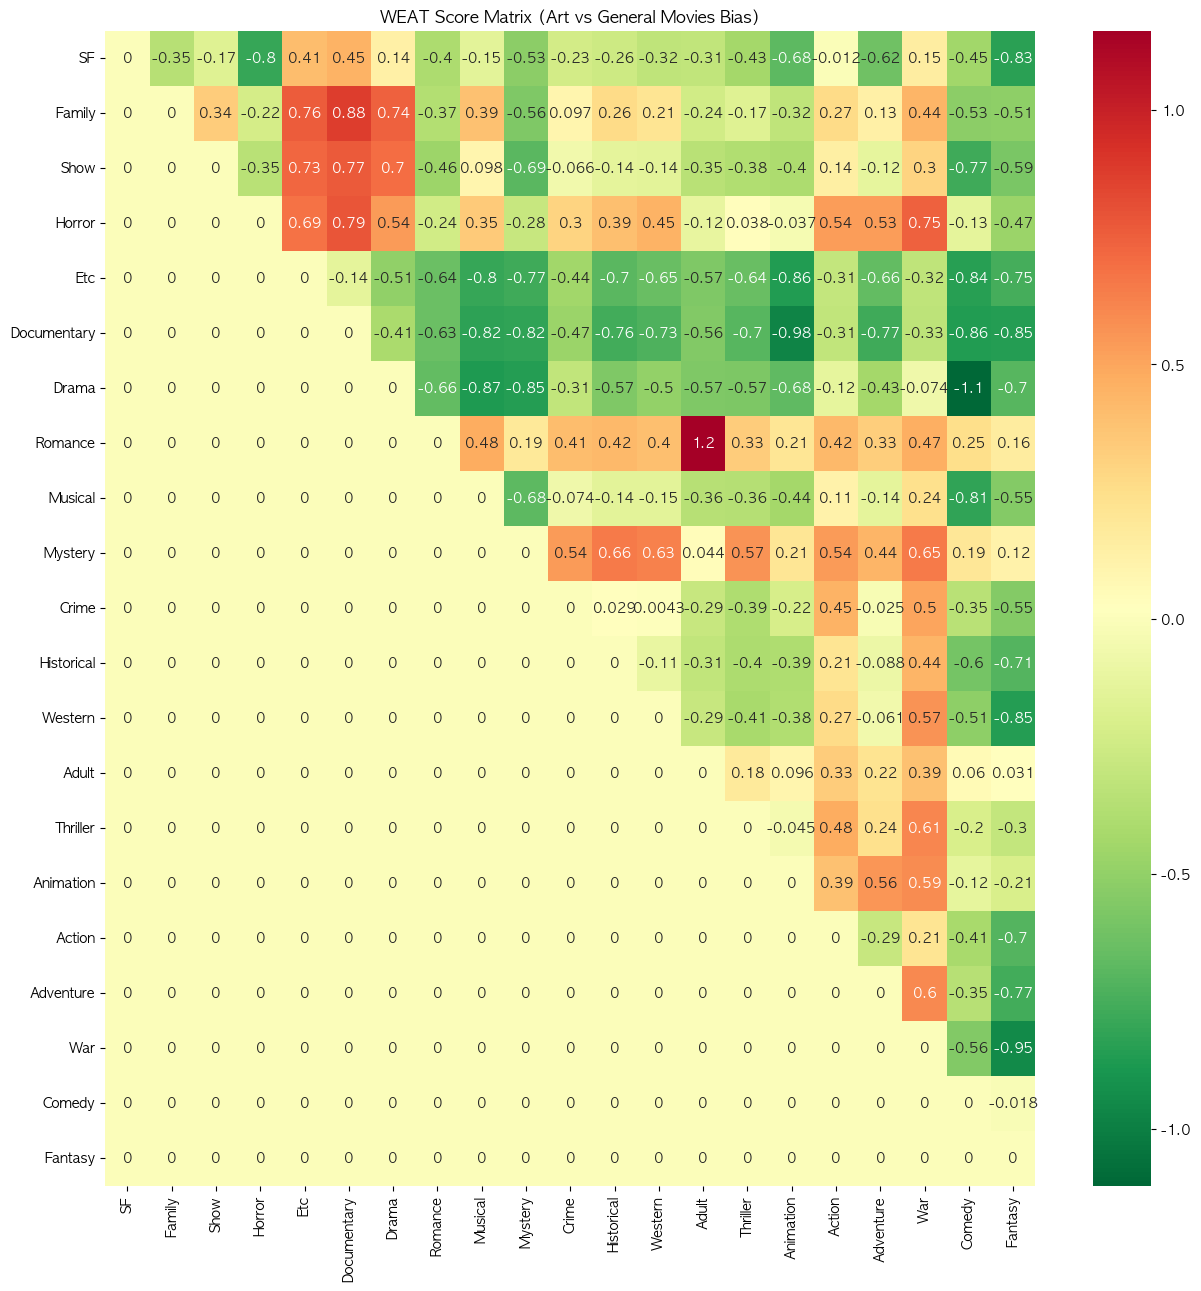

In [14]:
# 1. Define Cosine Similarity Function
def cos_sim(i, j):
    """
    Calculates cosine similarity between two vectors.
    """
    return np.dot(i, j.T) / (np.linalg.norm(i) * np.linalg.norm(j))

# 2. Define S-statistic Function for WEAT
def s(w, A, B):
    """
    Calculates the difference in similarity of word w to sets A and B.
    """
    c_a = cos_sim(w, A)  # Similarity with set A
    c_b = cos_sim(w, B)  # Similarity with set B
    mean_A = np.mean(c_a, axis=-1)  # Mean similarity to A
    mean_B = np.mean(c_b, axis=-1)  # Mean similarity to B
    return mean_A - mean_B

# 3. Define WEAT Score Function
def weat_score(X, Y, A, B):
    """
    Calculates the final WEAT score.
    X, Y: Target sets (e.g., Art vs Gen)
    A, B: Attribute sets (e.g., SF vs Romance)
    """
    s_X = s(X, A, B)  # s-values for Target X
    s_Y = s(Y, A, B)  # s-values for Target Y
    
    mean_X = np.mean(s_X) # Mean of s_X
    mean_Y = np.mean(s_Y) # Mean of s_Y
    
    # Standard deviation of combined s-values
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return (mean_X - mean_Y) / std_dev

# 4. Calculate Matrix (Target X vs Y against All Genres A vs B)
# Note: The rubric usually implies checking bias of X/Y against EACH genre.
# But following the typical matrix visualization structure:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

# Convert Target Words to Vectors
X_vec = np.array([model.wv[word] for word in target_art])
Y_vec = np.array([model.wv[word] for word in target_gen])

# Calculate Pairwise Genre Scores
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A_vec = np.array([model.wv[word] for word in attributes[i]])
        B_vec = np.array([model.wv[word] for word in attributes[j]])
        # Calculate score
        matrix[i][j] = weat_score(X_vec, Y_vec, A_vec, B_vec)

# 5. Visualization (Heatmap)
plt.figure(figsize=(15, 15))  # Set figure size
# Create Heatmap with annotations
sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, cmap='RdYlGn_r')
plt.title("WEAT Score Matrix (Art vs General Movies Bias)")  # Set title
plt.show()  # Display plot

양수일수록 예술영화 성향
일반영화 일수록 음수
중립적이면 0에 수렴

Step 7: 3D t-SNE

In [13]:
# 1. Collect words and vectors for visualization
embedding_clusters = []  # To store vectors
word_clusters = []       # To store words
labels = []              # To store category labels

# (1) Add Target Words (Art vs Gen)
for word in target_art:
    if word in model.wv:
        embedding_clusters.append(model.wv[word])
        word_clusters.append(word)
        labels.append('Art Movie')

for word in target_gen:
    if word in model.wv:
        embedding_clusters.append(model.wv[word])
        word_clusters.append(word)
        labels.append('General Movie')

# (2) Add Attribute Words (Genres)
for i in range(len(genre_name)):
    for word in attributes[i]:
        if word in model.wv:
            embedding_clusters.append(model.wv[word])
            word_clusters.append(word)
            labels.append(genre_name[i])

# 2. t-SNE Dimensionality Reduction (100D -> 3D)
print("Running t-SNE...")
tsne_model_en_3d = TSNE(perplexity=15, n_components=3, init='pca', n_iter_without_progress=3500, random_state=32)
embeddings_en_3d = np.array(embedding_clusters)
embeddings_en_3d = tsne_model_en_3d.fit_transform(embeddings_en_3d)

# 3. Create DataFrame for Plotting
tsne_df = pd.DataFrame(embeddings_en_3d, columns=['x', 'y', 'z'])
tsne_df['word'] = word_clusters
tsne_df['label'] = labels

# 4. Create 3D Scatter Plot
fig = px.scatter_3d(
    tsne_df, 
    x='x', 
    y='y', 
    z='z', 
    color='label',       # Color by category
    hover_name='word',   # Show word on hover
    symbol='label',      # Different symbols per category
    opacity=0.7,         # Transparency
    size_max=10,         # Max dot size
    title='Interactive 3D t-SNE Visualization'
)

# 5. Update Layout
fig.update_traces(marker=dict(size=5)) # Set consistent marker size
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40), # Reduce margins
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01), # Legend position
    height=800 # Figure height
)

# 6. Show Plot
fig.show(renderer="browser")

Running t-SNE...


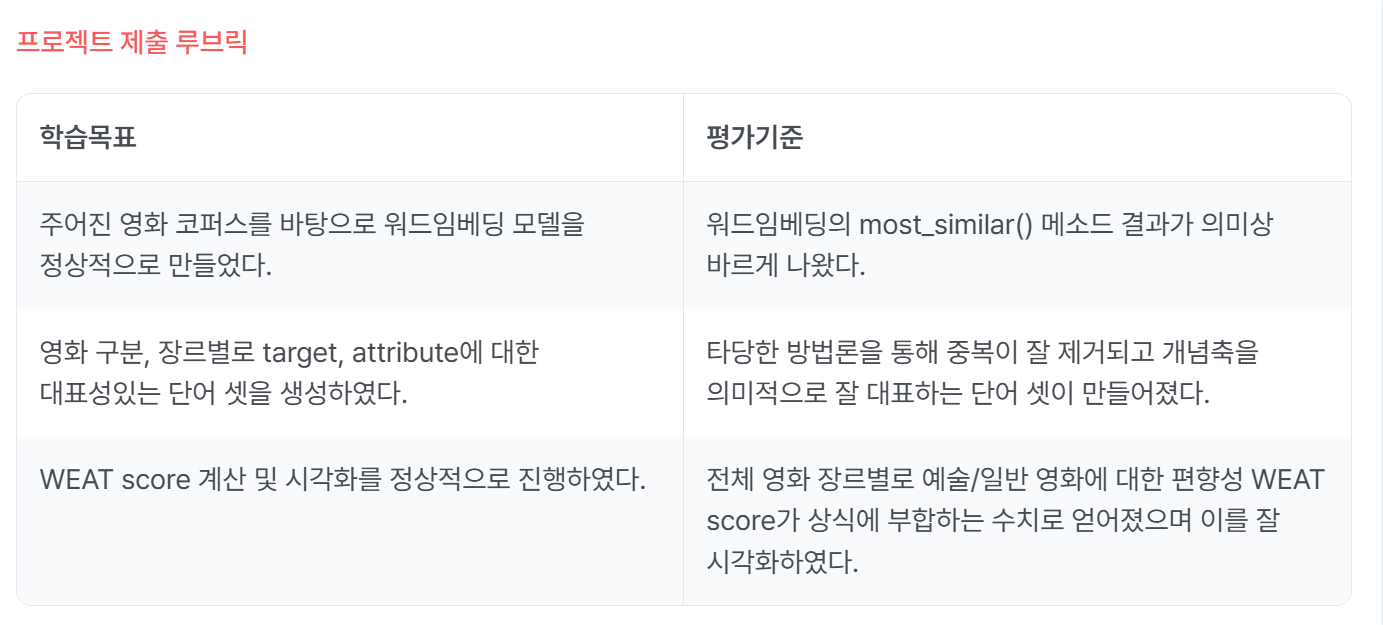



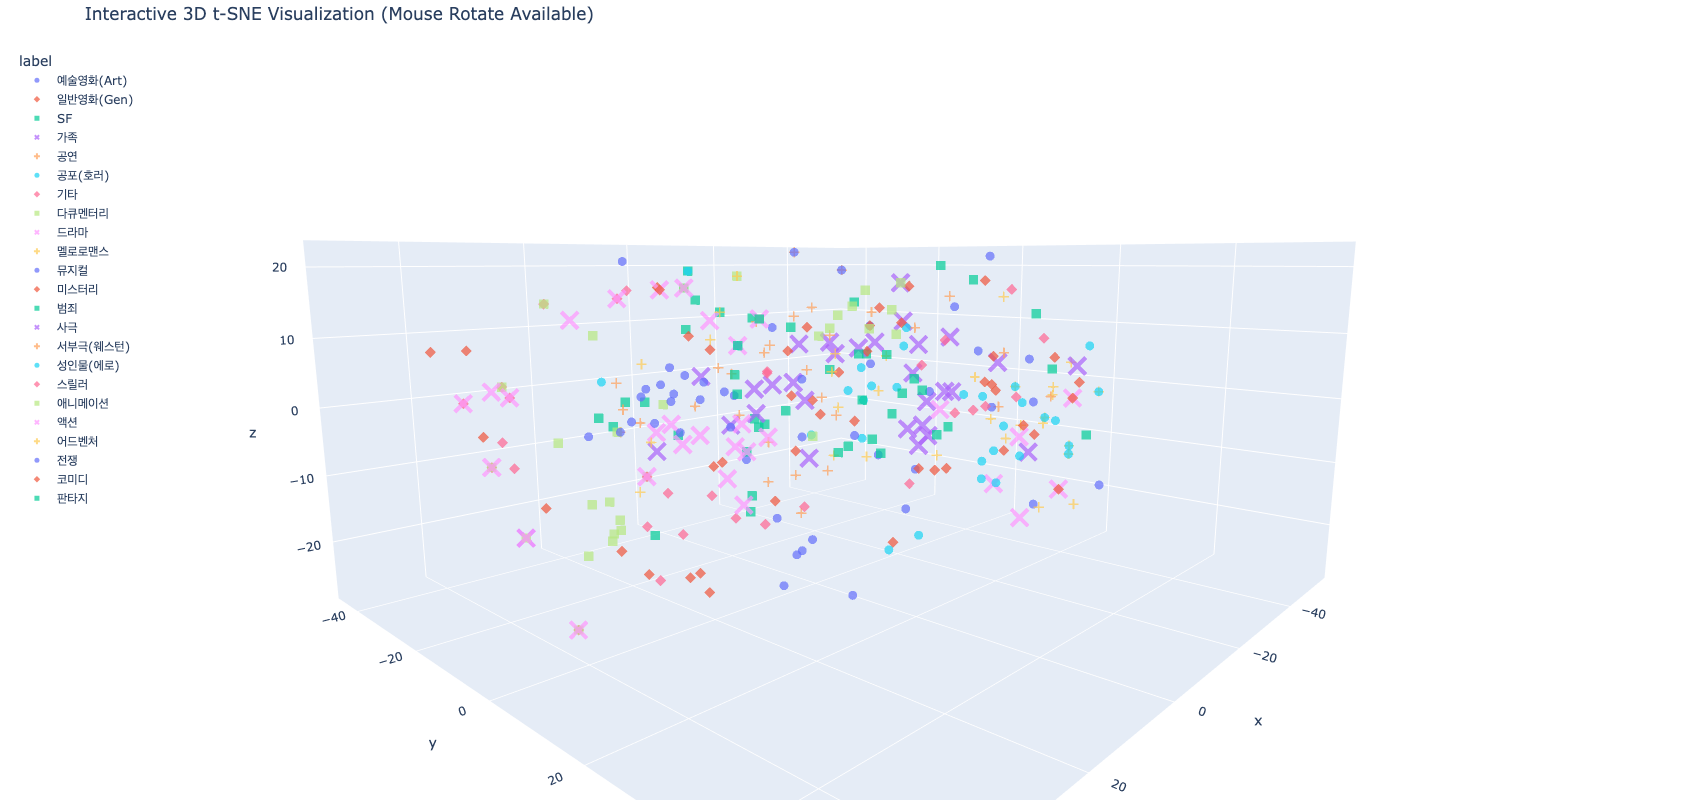

회고:

생각외로 TF-IDF 생성시 중복 단어 제거를 조금 신경쓰기만해도 WEAT Score에 영향을 많이주는게 인상깊었다
T-SNE도 3D라 신기했으나 뭐라 분석을 하기가 어려웠다